[*********************100%***********************]  1 of 1 completed


Summary Statistics:
 Price         Close
Ticker         AAPL
count   2264.000000
mean      81.673040
std       56.182340
min       20.674532
25%       32.926902
50%       51.395992
75%      139.492996
max      196.927673


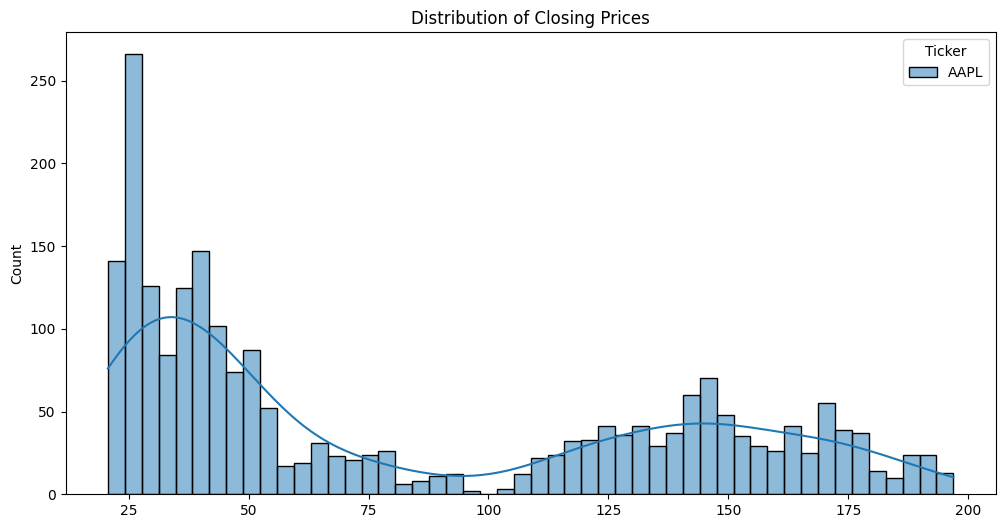

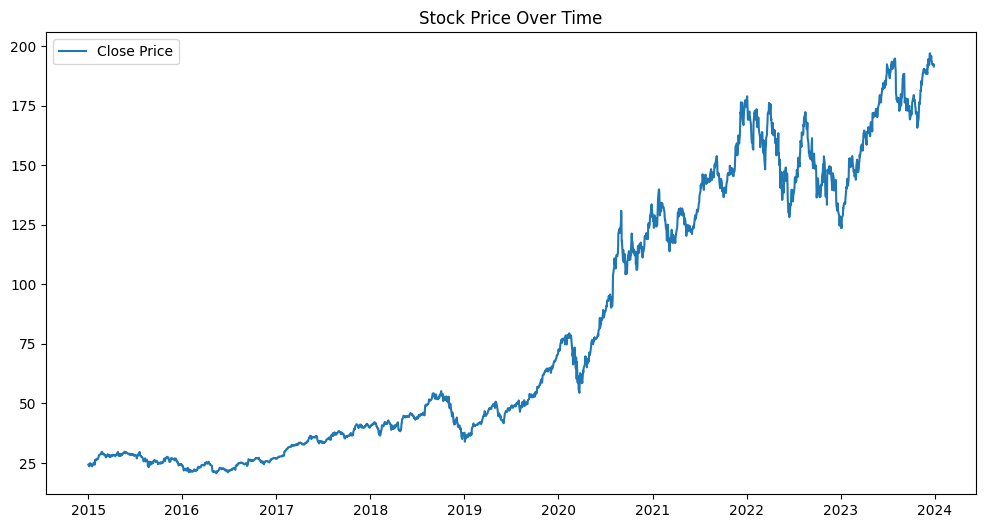

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.0199 - val_loss: 0.0014
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 9.5271e-04 - val_loss: 0.0017
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 8.2568e-04 - val_loss: 0.0070
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 7.7394e-04 - val_loss: 0.0030
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 9.6598e-04 - val_loss: 0.0012
Epoch 12/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss

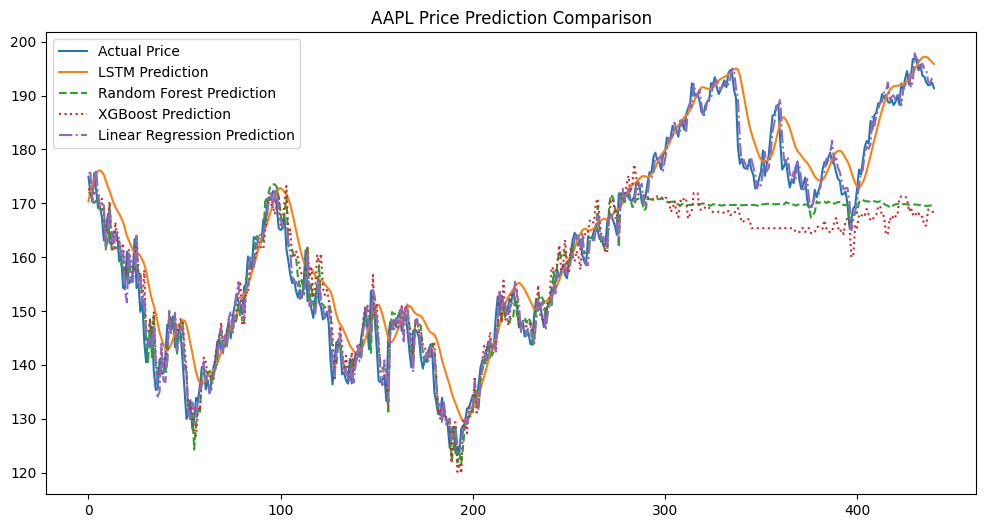

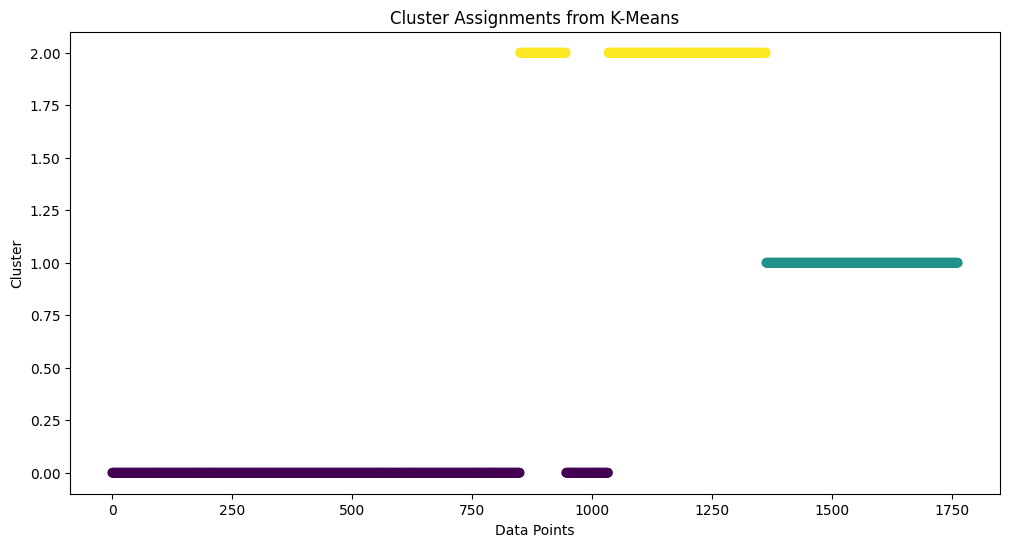

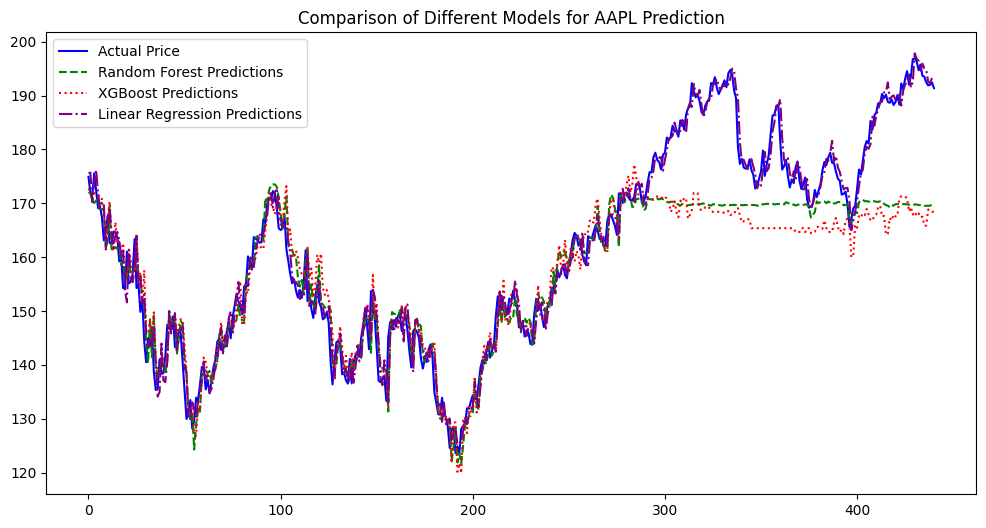

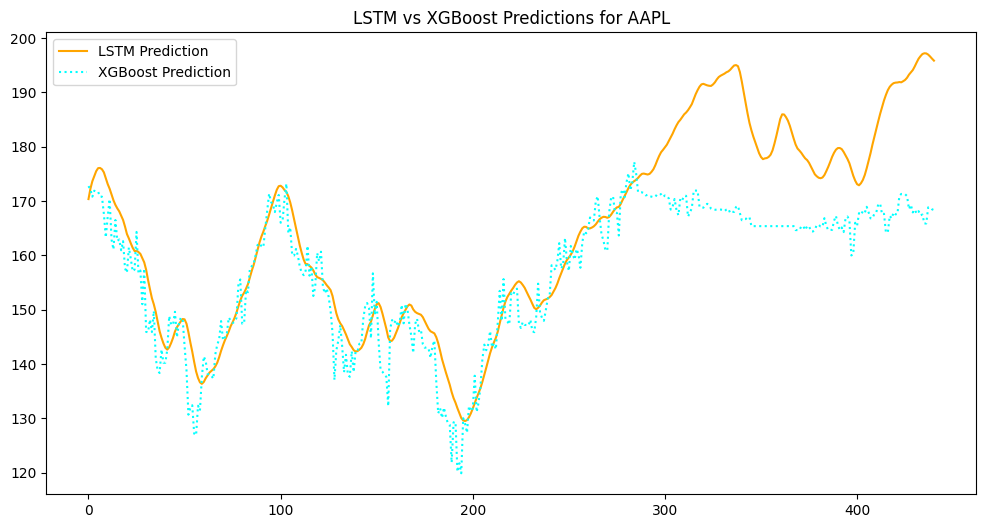

In [18]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def download_stock_data(ticker, start='2015-01-01', end='2024-01-01'):
    stock = yf.download(ticker, start=start, end=end)
    return stock[['Close']]

def perform_eda(df):
    print("Summary Statistics:\n", df.describe())

    plt.figure(figsize=(12, 6))
    sns.histplot(df['Close'], bins=50, kde=True)
    plt.title('Distribution of Closing Prices')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(df['Close'], label='Close Price')
    plt.title('Stock Price Over Time')
    plt.legend()
    plt.show()

def prepare_data(df, time_steps=60):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)

    X, y = [], []
    for i in range(time_steps, len(df_scaled)):
        X.append(df_scaled[i-time_steps:i, 0])
        y.append(df_scaled[i, 0])

    X, y = np.array(X), np.array(y)
    return X.reshape(X.shape[0], X.shape[1], 1), y, scaler

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
linear_model = LinearRegression()
kmeans = KMeans(n_clusters=3, random_state=42)

if __name__ == "__main__":
    ticker = 'AAPL'
    stock_data = download_stock_data(ticker)

    perform_eda(stock_data)

    X, y, scaler = prepare_data(stock_data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    lstm_model = build_lstm_model((X_train.shape[1], 1))
    lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

    lstm_predictions = lstm_model.predict(X_test)
    lstm_predictions = scaler.inverse_transform(lstm_predictions.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    rf_model.fit(X_train_flat, y_train)
    xgb_model.fit(X_train_flat, y_train)
    linear_model.fit(X_train_flat, y_train)

    rf_predictions = rf_model.predict(X_test_flat).reshape(-1, 1)
    xgb_predictions = xgb_model.predict(X_test_flat).reshape(-1, 1)
    linear_predictions = linear_model.predict(X_test_flat).reshape(-1, 1)

    rf_predictions = scaler.inverse_transform(rf_predictions)
    xgb_predictions = scaler.inverse_transform(xgb_predictions)
    linear_predictions = scaler.inverse_transform(linear_predictions)

    clusters = kmeans.fit_predict(X_train_flat)

    plt.figure(figsize=(12, 6))
    plt.plot(y_test_actual, label='Actual Price')
    plt.plot(lstm_predictions, label='LSTM Prediction')
    plt.plot(rf_predictions, label='Random Forest Prediction', linestyle='dashed')
    plt.plot(xgb_predictions, label='XGBoost Prediction', linestyle='dotted')
    plt.plot(linear_predictions, label='Linear Regression Prediction', linestyle='dashdot')
    plt.legend()
    plt.title(f'{ticker} Price Prediction Comparison')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(clusters)), clusters, c=clusters, cmap='viridis')
    plt.title('Cluster Assignments from K-Means')
    plt.xlabel('Data Points')
    plt.ylabel('Cluster')
    plt.show()


    plt.figure(figsize=(12, 6))
    plt.plot(lstm_predictions, label='LSTM Prediction', color='orange')
    plt.plot(xgb_predictions, label='XGBoost Prediction', color='cyan', linestyle='dotted')
    plt.legend()
    plt.title(f'LSTM vs XGBoost Predictions for {ticker}')
    plt.show()
